<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/Polyakov-Alexander-branch/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependency

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [3]:
def display_images(images, n):
    """Отображает первые n изображений из переданного списка."""

    plt.figure(figsize=(20, 5))

    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

    plt.show()

In [6]:
class ImageLoader:

    def __init__(self, images_path):
        self.images_path = images_path

    def load_images(self, subfolders):
        images = []
        for subfolder in subfolders:
            full_path = os.path.join(self.images_path, subfolder)
            image_names = os.listdir(full_path)

            for image_name in image_names:
                img_path = os.path.join(full_path, image_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Чтение в черно-белом формате
                img = cv2.resize(img, (128, 128))  # Изменение размера изображения
                img = img.reshape(128, 128, 1)     # Изменение формы
                images.append(img)

        images = np.array(images) / 255.0 # Нормализация
        return images

In [61]:
from sklearn.metrics import mean_squared_error

class AutoencoderPredictor:

    def __init__(self, model, image_size, threshold=0.001905):
        self.autoencoder = model
        self.image_size = image_size
        self.threshold = threshold

    def predict_error(self, image):
        """Прогнозирование и вычисление ошибки для заданного изображения."""

        # Предсказание для переданного изображения
        pred = self.autoencoder.predict(image.reshape(1, *image.shape))

        # Подсчет ошибки
        err = mean_squared_error(image.reshape(-1, self.image_size),
                                 pred.reshape(-1, self.image_size))

        return err

    def predict_threshold(self, image):
        """Возвращает 1, если ошибка превышает порог, иначе 0."""

        error = self.predict_error(image)

        if error > self.threshold:
            return 0
        else:
            return 1

## Загрузка изображений

In [4]:
IMAGES_PATH = '/content/drive/MyDrive/AI/datasets/plastIron/'
SUBFOLDERS = ['iron', 'plastic']

In [7]:
loader = ImageLoader(IMAGES_PATH)
images_list = loader.load_images(SUBFOLDERS)

X_train, X_test = train_test_split(images_list, test_size=0.2, random_state=42)

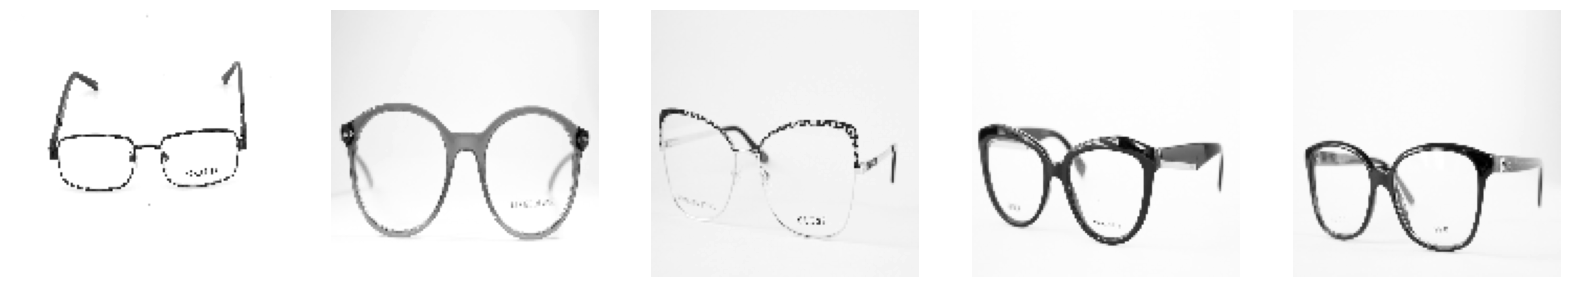

In [8]:
n = 5
display_images(X_train, n)

## Закгрузка проверочных изображений не очков

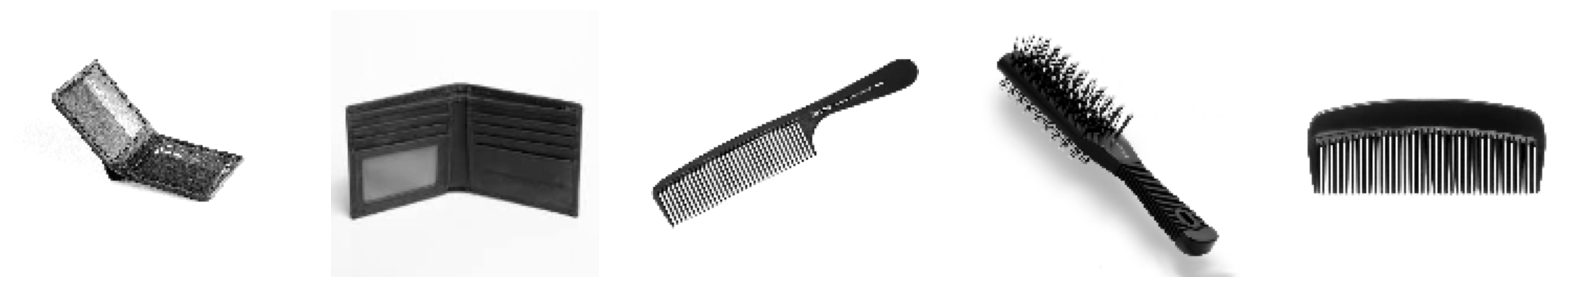

In [9]:
stuff_images_list = loader.load_images(['stuff'])
display_images(stuff_images_list, n)

## Кодировщик

In [10]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)


    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)


    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs)

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

    # Возврат готовой модели
    return model

In [11]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5):

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [32]:
# Обучение автоэнкодера
autoencoder = create_base_ae(X_train.shape[1:])
# Создание ModelCheckpoint callback
model_save_path = '/content/drive/MyDrive/AI/saved_models/best_autoencoder.h5'  # Измените путь, если нужно
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Создание EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=1000,
    batch_size=30,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[checkpoint, early_stopping])

Epoch 1/1000
24/24 [==============================] - ETA: 0s - loss: 0.2362
Epoch 1: val_loss improved from inf to 0.20962, saving model to /content/drive/MyDrive/AI/saved_models/best_autoencoder.h5
24/24 [==============================] - 26s 239ms/step - loss: 0.2362 - val_loss: 0.2096
Epoch 2/1000
24/24 [==============================] - ETA: 0s - loss: 0.1805
Epoch 2: val_loss improved from 0.20962 to 0.17104, saving model to /content/drive/MyDrive/AI/saved_models/best_autoencoder.h5
24/24 [==============================] - 3s 115ms/step - loss: 0.1805 - val_loss: 0.1710
Epoch 3/1000
24/24 [==============================] - ETA: 0s - loss: 0.1389
Epoch 3: val_loss improved from 0.17104 to 0.12184, saving model to /content/drive/MyDrive/AI/saved_models/best_autoencoder.h5
24/24 [==============================] - 3s 110ms/step - loss: 0.1389 - val_loss: 0.1218
Epoch 4/1000
24/24 [==============================] - ETA: 0s - loss: 0.1080
Epoch 4: val_loss improved from 0.12184 to 0.08

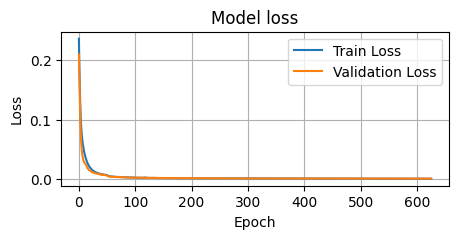

In [33]:
# Визуализация истории обучения
plt.figure(figsize=(5, 2))

# График потерь на тренировочных данных и валидационных данных
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Сохраненая модель

In [13]:
from tensorflow.keras.models import load_model
model_save_path = '/content/drive/MyDrive/AI/saved_models/best_autoencoder.h5'
# Загрузка модели
autoencoder = load_model(model_save_path)

In [14]:
pred_test = autoencoder.predict(X_test)

6/6 [==============================] - 17s 3s/step


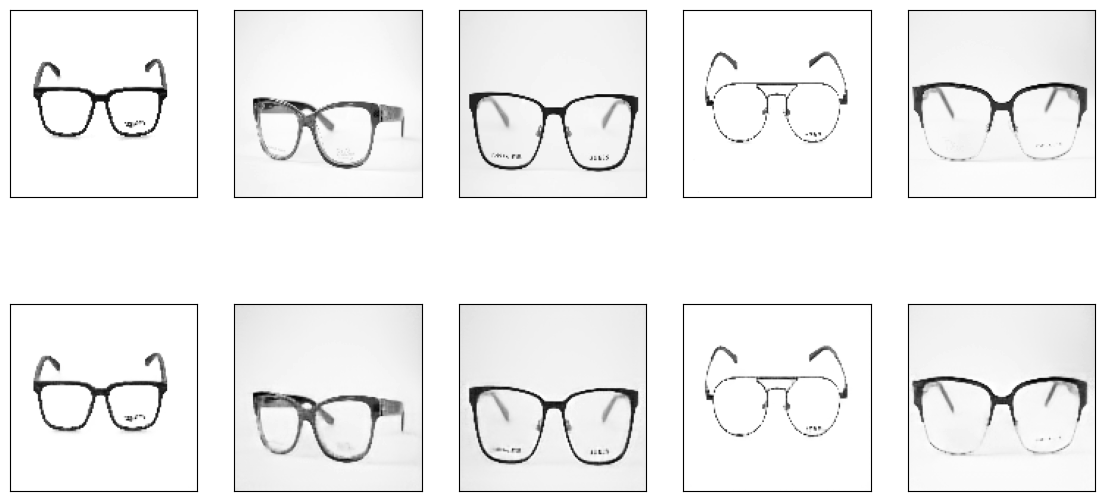

In [15]:
plot_images(X_test, pred_test)

In [19]:
# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

In [21]:
# Расчет количества пикселей
image_size = X_train.shape[1] * X_train.shape[2]
image_size

16384

In [107]:
pred_test = autoencoder.predict(X_test)
pred_train = autoencoder.predict(X_train)

err_train = mean_squared_error(X_train.reshape(-1, image_size).T,
                                     pred_train.reshape(-1, image_size).T,
                                     multioutput='raw_values')
err_test = mean_squared_error(X_test.reshape(-1, image_size).T,
                                    pred_test.reshape(-1, image_size).T,
                                    multioutput='raw_values')

# Вывод средних ошибок
print(f'Средняя ошибка на обучающем наборе: {err_train.mean()}')
print(f'Средняя ошибка на тестовом наборе: {err_test.mean()}')

23/23 [==============================] - 58s 3s/step
Средняя ошибка на обучающем наборе: 0.0003836658303031814
Средняя ошибка на тестовом наборе: 0.00047875353963621343


In [109]:
pred_test = autoencoder.predict(X_test)
pred_stuff = autoencoder.predict(stuff_images_list)

err_test = mean_squared_error(X_test.reshape(-1, image_size).T,
                                    pred_test.reshape(-1, image_size).T,
                                    multioutput='raw_values')
err_stuff = mean_squared_error(stuff_images_list.reshape(-1, image_size).T,
                                    pred_stuff.reshape(-1, image_size).T,
                                    multioutput='raw_values')

print('Средняя ошибка на test: {:.5f}'.format(err_test.mean()))
print('Средняя ошибка на stuff: {:.5f}'.format(err_stuff.mean()))

2/2 [==============================] - 3s 1s/step
Средняя ошибка на test: 0.00048
Средняя ошибка на stuff: 0.00368


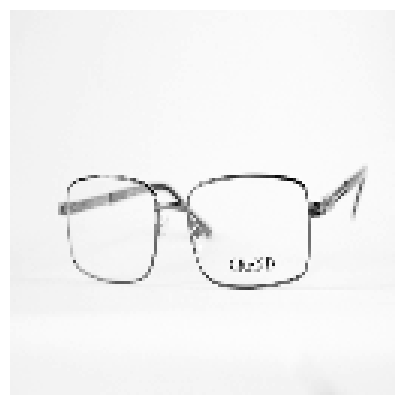

1/1 [==============================] - 0s 90ms/step
Ошибка для изображения: 0.0003618331453225154
Очки


In [110]:
stuff_img = X_test[6]
# stuff_img = stuff_images_list[4]
display_images([stuff_img], 1)

image_size = stuff_img.shape[0] * stuff_img.shape[1]
image_size

predictor = AutoencoderPredictor(autoencoder, image_size)
error = predictor.predict_error(stuff_img)
result = predictor.predict_threshold(stuff_img)

print(f"Ошибка для изображения: {error}")


if result == 1:
  print("Очки")
else:
 print("Не очки")

1/1 [==============================] - 0s 82ms/step


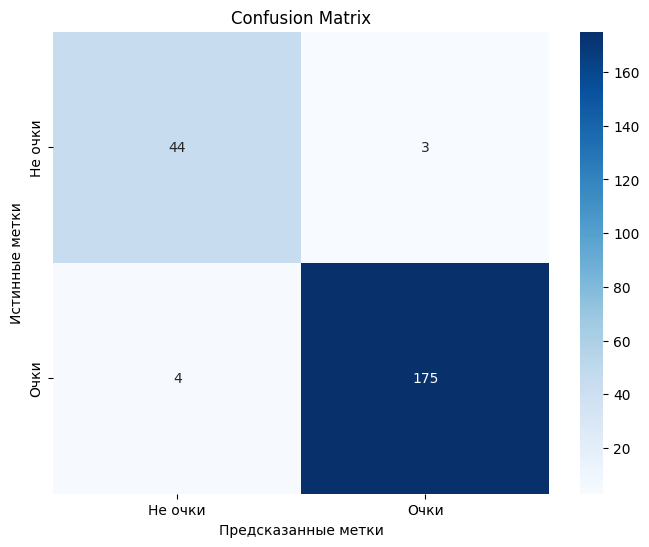

In [97]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

stuff_images_list = loader.load_images(['stuff'])
image_size = X_test[0].shape[0] * X_test[0].shape[1]
predictor = AutoencoderPredictor(autoencoder, image_size, 0.001)

# Составьте список истинных меток и предсказаний
y_true = [1] * len(X_test) + [0] * len(stuff_images_list)
y_pred = []

# Предсказания для X_test (Очки)
for img in X_test:
    y_pred.append(predictor.predict_threshold(img))

# Предсказания для stuff_images_list (Не очки)
for img in stuff_images_list:
    y_pred.append(predictor.predict_threshold(img))

# Вычисление confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Не очки', 'Очки'], yticklabels=['Не очки', 'Очки'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 85ms/step
Количество ошибочно классифицированных изображений: 3


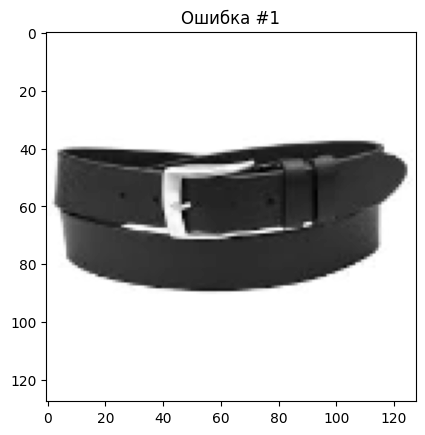

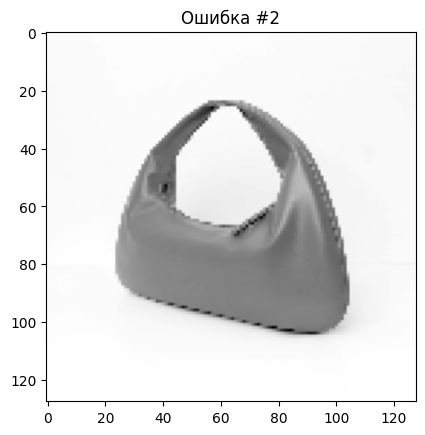

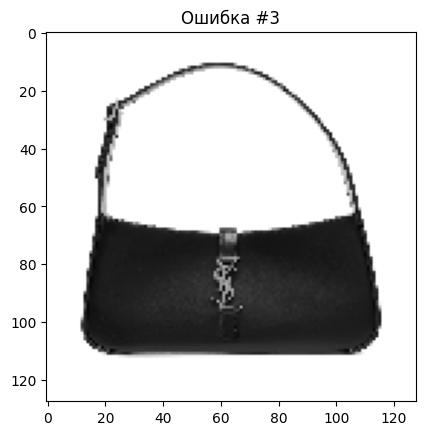

In [98]:
# Получение ошибочных изображений
misclassified_images = []

for idx, img in enumerate(stuff_images_list):
    prediction = predictor.predict_threshold(img)

    # Если предсказание гласит "Очки", хотя это "Не очки"
    if prediction == 1:
        misclassified_images.append(img)

print(f"Количество ошибочно классифицированных изображений: {len(misclassified_images)}")

# Отображение первых нескольких ошибочных изображений (если они есть)
if misclassified_images:
    num_display = len(misclassified_images)
    for i in range(num_display):
        plt.imshow(misclassified_images[i], cmap='gray')
        plt.title(f"Ошибка #{i+1}")
        plt.show()
